In [2]:
import torch
import pandas as pd
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import timeit
from tqdm import tqdm

In [3]:
RANDOM_SEED = 42
BATCH_SIZE = 512
EPOCHS = 40
LEARNING_RATE = 1e-4
NUM_CLASSES = 10
PATCH_SIZE = 4
IMG_SIZE = 28
IN_CHANNELS = 1
NUM_HEADS = 8
DROPOUT = 0.001
HIDDEN_DIM = 768
ADAM_WEIGHT_DECAY = 0
ADAM_BETAS = (0.9, 0.999)
ACTIVATION="gelu"
NUM_ENCODERS = 4
EMBED_DIM = (PATCH_SIZE ** 2) * IN_CHANNELS # 16
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2 # 49

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
class PatchEmbedding(nn.Module):
    def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channels):
        super().__init__()
        self.patcher = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=embed_dim,
                kernel_size=patch_size,
                stride=patch_size,
            ),
            nn.Flatten(2))

        self.cls_token = nn.Parameter(torch.randn(size=(1, in_channels, embed_dim)), requires_grad=True)
        self.position_embeddings = nn.Parameter(torch.randn(size=(1, num_patches+1, embed_dim)), requires_grad=True)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)

        x = self.patcher(x).permute(0, 2, 1)
        x = torch.cat([cls_token, x], dim=1)
        x = self.position_embeddings + x
        x = self.dropout(x)
        return x

model = PatchEmbedding(EMBED_DIM, PATCH_SIZE, NUM_PATCHES, DROPOUT, IN_CHANNELS).to(device)
x = torch.randn(512, 1, 28, 28).to(device)
print(model(x).shape)

torch.Size([512, 50, 16])


In [5]:
class ViT(nn.Module):
    def __init__(self, num_patches, img_size, num_classes, patch_size, embed_dim, num_encoders, num_heads, hidden_dim, dropout, activation, in_channels):
        super().__init__()
        self.embeddings_block = PatchEmbedding(embed_dim, patch_size, num_patches, dropout, in_channels)

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout, activation=activation, batch_first=True, norm_first=True)
        self.encoder_blocks = nn.TransformerEncoder(encoder_layer, num_layers=num_encoders)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embed_dim),
            nn.Linear(in_features=embed_dim, out_features=num_classes)
        )

    def forward(self, x):
        x = self.embeddings_block(x)
        x = self.encoder_blocks(x)
        x = self.mlp_head(x[:, 0, :])  # Apply MLP on the CLS token only
        return x

model = ViT(NUM_PATCHES, IMG_SIZE, NUM_CLASSES, PATCH_SIZE, EMBED_DIM, NUM_ENCODERS, NUM_HEADS, HIDDEN_DIM, DROPOUT, ACTIVATION, IN_CHANNELS).to(device)
x = torch.randn(512, 1, 28, 28).to(device)
print(model(x).shape) # BATCH_SIZE X NUM_CLASSES

torch.Size([512, 10])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [6]:
train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")
submission_df = pd.read_csv("/content/sample_submission.csv")

In [7]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
test_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
submission_df.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [10]:
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=RANDOM_SEED, shuffle=True)

In [11]:
class MNISTTrainDataset(Dataset):
    def __init__(self, images, labels, indicies):
        self.images = images
        self.labels = labels
        self.indicies = indicies
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].reshape((28, 28)).astype(np.uint8)
        label = self.labels[idx]
        index = self.indicies[idx]
        image = self.transform(image)

        return {"image": image, "label": label, "index": index}

class MNISTValDataset(Dataset):
    def __init__(self, images, labels, indicies):
        self.images = images
        self.labels = labels
        self.indicies = indicies
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].reshape((28, 28)).astype(np.uint8)
        label = self.labels[idx]
        index = self.indicies[idx]
        image = self.transform(image)

        return {"image": image, "label": label, "index": index}

class MNISTSubmitDataset(Dataset):
    def __init__(self, images, indicies):
        self.images = images
        self.indicies = indicies
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].reshape((28, 28)).astype(np.uint8)
        index = self.indicies[idx]
        image = self.transform(image)

        return {"image": image, "index": index}

37800
{'image': tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0

<Figure size 640x480 with 0 Axes>

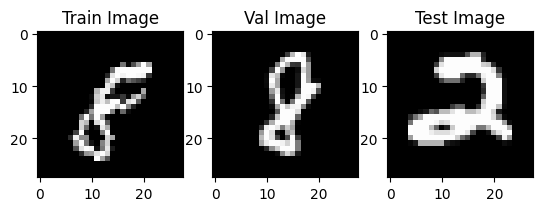

In [12]:
plt.figure()
f, axarr = plt.subplots(1, 3)

train_dataset = MNISTTrainDataset(train_df.iloc[:, 1:].values.astype(np.uint8), train_df.iloc[:, 0].values, train_df.index.values)
print(len(train_dataset))
print(train_dataset[0])
axarr[0].imshow(train_dataset[0]["image"].squeeze(), cmap="gray")
axarr[0].set_title("Train Image")
print("-"*30)

val_dataset = MNISTValDataset(val_df.iloc[:, 1:].values.astype(np.uint8), val_df.iloc[:, 0].values, val_df.index.values)
print(len(val_dataset))
print(val_dataset[0])
axarr[1].imshow(val_dataset[0]["image"].squeeze(), cmap="gray")
axarr[1].set_title("Val Image")
print("-"*30)

test_dataset = MNISTSubmitDataset(test_df.values.astype(np.uint8), test_df.index.values)
print(len(test_dataset))
print(test_dataset[0])
axarr[2].imshow(test_dataset[0]["image"].squeeze(), cmap="gray")
axarr[2].set_title("Test Image")
print("-"*30)

plt.show()

In [13]:
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

val_dataloader = DataLoader(dataset=val_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), betas=ADAM_BETAS, lr=LEARNING_RATE, weight_decay=ADAM_WEIGHT_DECAY)

start = timeit.default_timer()
for epoch in tqdm(range(EPOCHS), position=0, leave=True):
    model.train()
    train_labels = []
    train_preds = []
    train_running_loss = 0
    for idx, img_label in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        img = img_label["image"].float().to(device)
        label = img_label["label"].type(torch.uint8).to(device)
        y_pred = model(img)
        y_pred_label = torch.argmax(y_pred, dim=1)

        train_labels.extend(label.cpu().detach())
        train_preds.extend(y_pred_label.cpu().detach())

        loss = criterion(y_pred, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item()
    train_loss = train_running_loss / (idx + 1)

    model.eval()
    val_labels = []
    val_preds = []
    val_running_loss = 0
    with torch.no_grad():
        for idx, img_label in enumerate(tqdm(val_dataloader, position=0, leave=True)):
            img = img_label["image"].float().to(device)
            label = img_label["label"].type(torch.uint8).to(device)
            y_pred = model(img)
            y_pred_label = torch.argmax(y_pred, dim=1)

            val_labels.extend(label.cpu().detach())
            val_preds.extend(y_pred_label.cpu().detach())

            loss = criterion(y_pred, label)
            val_running_loss += loss.item()
    val_loss = val_running_loss / (idx + 1)

    print("-"*30)
    print(f"Train Loss EPOCH {epoch+1}: {train_loss:.4f}")
    print(f"Valid Loss EPOCH {epoch+1}: {val_loss:.4f}")
    print(f"Train Accuracy EPOCH {epoch+1}: {sum(1 for x,y in zip(train_preds, train_labels) if x == y) / len(train_labels):.4f}")
    print(f"Valid Accuracy EPOCH {epoch+1}: {sum(1 for x,y in zip(val_preds, val_labels) if x == y) / len(val_labels):.4f}")
    print("-"*30)

stop = timeit.default_timer()
print(f"Training Time: {stop-start:.2f}s")

100%|██████████| 9/9 [00:00<00:00,  9.03it/s]


------------------------------
Train Loss EPOCH 1: 2.2573
Valid Loss EPOCH 1: 2.0988


  2%|▎         | 1/40 [00:23<15:01, 23.10s/it]

Train Accuracy EPOCH 1: 0.1613
Valid Accuracy EPOCH 1: 0.2433
------------------------------


100%|██████████| 9/9 [00:00<00:00, 12.25it/s]


------------------------------
Train Loss EPOCH 2: 2.0112
Valid Loss EPOCH 2: 1.8102


  5%|▌         | 2/40 [00:45<14:32, 22.96s/it]

Train Accuracy EPOCH 2: 0.2700
Valid Accuracy EPOCH 2: 0.3729
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.49it/s]


------------------------------
Train Loss EPOCH 3: 1.6986
Valid Loss EPOCH 3: 1.5179


  8%|▊         | 3/40 [01:08<14:04, 22.82s/it]

Train Accuracy EPOCH 3: 0.4236
Valid Accuracy EPOCH 3: 0.5038
------------------------------


100%|██████████| 9/9 [00:00<00:00, 10.33it/s]


------------------------------
Train Loss EPOCH 4: 1.5197
Valid Loss EPOCH 4: 1.3830


 10%|█         | 4/40 [01:30<13:32, 22.56s/it]

Train Accuracy EPOCH 4: 0.5010
Valid Accuracy EPOCH 4: 0.5771
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.75it/s]


------------------------------
Train Loss EPOCH 5: 1.3998
Valid Loss EPOCH 5: 1.2657


 12%|█▎        | 5/40 [01:55<13:31, 23.18s/it]

Train Accuracy EPOCH 5: 0.5541
Valid Accuracy EPOCH 5: 0.6264
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.59it/s]


------------------------------
Train Loss EPOCH 6: 1.2811
Valid Loss EPOCH 6: 1.1353


 15%|█▌        | 6/40 [02:17<13:01, 22.98s/it]

Train Accuracy EPOCH 6: 0.6130
Valid Accuracy EPOCH 6: 0.6800
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.48it/s]


------------------------------
Train Loss EPOCH 7: 1.1658
Valid Loss EPOCH 7: 1.0387


 18%|█▊        | 7/40 [02:40<12:31, 22.79s/it]

Train Accuracy EPOCH 7: 0.6716
Valid Accuracy EPOCH 7: 0.7319
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.75it/s]


------------------------------
Train Loss EPOCH 8: 1.0595
Valid Loss EPOCH 8: 0.9497


 20%|██        | 8/40 [03:01<12:00, 22.51s/it]

Train Accuracy EPOCH 8: 0.7136
Valid Accuracy EPOCH 8: 0.7600
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.86it/s]


------------------------------
Train Loss EPOCH 9: 0.9742
Valid Loss EPOCH 9: 0.8459


 22%|██▎       | 9/40 [03:24<11:33, 22.37s/it]

Train Accuracy EPOCH 9: 0.7418
Valid Accuracy EPOCH 9: 0.7940
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.94it/s]


------------------------------
Train Loss EPOCH 10: 0.8967
Valid Loss EPOCH 10: 0.8006


 25%|██▌       | 10/40 [03:45<11:07, 22.23s/it]

Train Accuracy EPOCH 10: 0.7628
Valid Accuracy EPOCH 10: 0.8017
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.35it/s]


------------------------------
Train Loss EPOCH 11: 0.8424
Valid Loss EPOCH 11: 0.7398


 28%|██▊       | 11/40 [04:07<10:37, 21.99s/it]

Train Accuracy EPOCH 11: 0.7780
Valid Accuracy EPOCH 11: 0.8200
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.46it/s]


------------------------------
Train Loss EPOCH 12: 0.7984
Valid Loss EPOCH 12: 0.7055


 30%|███       | 12/40 [04:29<10:17, 22.07s/it]

Train Accuracy EPOCH 12: 0.7895
Valid Accuracy EPOCH 12: 0.8274
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.43it/s]


------------------------------
Train Loss EPOCH 13: 0.7550
Valid Loss EPOCH 13: 0.6917


 32%|███▎      | 13/40 [04:51<09:55, 22.07s/it]

Train Accuracy EPOCH 13: 0.8005
Valid Accuracy EPOCH 13: 0.8298
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.25it/s]


------------------------------
Train Loss EPOCH 14: 0.7213
Valid Loss EPOCH 14: 0.6298


 35%|███▌      | 14/40 [05:12<09:27, 21.82s/it]

Train Accuracy EPOCH 14: 0.8096
Valid Accuracy EPOCH 14: 0.8410
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.46it/s]


------------------------------
Train Loss EPOCH 15: 0.6693
Valid Loss EPOCH 15: 0.5771


 38%|███▊      | 15/40 [05:35<09:10, 22.00s/it]

Train Accuracy EPOCH 15: 0.8272
Valid Accuracy EPOCH 15: 0.8650
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.91it/s]


------------------------------
Train Loss EPOCH 16: 0.6450
Valid Loss EPOCH 16: 0.5558


 40%|████      | 16/40 [05:58<08:53, 22.23s/it]

Train Accuracy EPOCH 16: 0.8329
Valid Accuracy EPOCH 16: 0.8743
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.21it/s]


------------------------------
Train Loss EPOCH 17: 0.6115
Valid Loss EPOCH 17: 0.5563


 42%|████▎     | 17/40 [06:19<08:26, 22.02s/it]

Train Accuracy EPOCH 17: 0.8410
Valid Accuracy EPOCH 17: 0.8631
------------------------------


100%|██████████| 9/9 [00:00<00:00, 12.00it/s]


------------------------------
Train Loss EPOCH 18: 0.5786
Valid Loss EPOCH 18: 0.5151


 45%|████▌     | 18/40 [06:41<08:03, 21.99s/it]

Train Accuracy EPOCH 18: 0.8502
Valid Accuracy EPOCH 18: 0.8745
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.56it/s]


------------------------------
Train Loss EPOCH 19: 0.5562
Valid Loss EPOCH 19: 0.4837


 48%|████▊     | 19/40 [07:03<07:42, 22.05s/it]

Train Accuracy EPOCH 19: 0.8557
Valid Accuracy EPOCH 19: 0.8914
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.53it/s]


------------------------------
Train Loss EPOCH 20: 0.5278
Valid Loss EPOCH 20: 0.4370


 50%|█████     | 20/40 [07:25<07:18, 21.93s/it]

Train Accuracy EPOCH 20: 0.8628
Valid Accuracy EPOCH 20: 0.9012
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.54it/s]


------------------------------
Train Loss EPOCH 21: 0.5041
Valid Loss EPOCH 21: 0.4229


 52%|█████▎    | 21/40 [07:47<06:59, 22.06s/it]

Train Accuracy EPOCH 21: 0.8696
Valid Accuracy EPOCH 21: 0.9014
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.73it/s]


------------------------------
Train Loss EPOCH 22: 0.4914
Valid Loss EPOCH 22: 0.4246


 55%|█████▌    | 22/40 [08:10<06:38, 22.15s/it]

Train Accuracy EPOCH 22: 0.8727
Valid Accuracy EPOCH 22: 0.8955
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.70it/s]


------------------------------
Train Loss EPOCH 23: 0.4605
Valid Loss EPOCH 23: 0.3953


 57%|█████▊    | 23/40 [08:32<06:16, 22.17s/it]

Train Accuracy EPOCH 23: 0.8813
Valid Accuracy EPOCH 23: 0.9090
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.56it/s]


------------------------------
Train Loss EPOCH 24: 0.4448
Valid Loss EPOCH 24: 0.3945


 60%|██████    | 24/40 [08:55<05:56, 22.31s/it]

Train Accuracy EPOCH 24: 0.8832
Valid Accuracy EPOCH 24: 0.9052
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.06it/s]


------------------------------
Train Loss EPOCH 25: 0.4260
Valid Loss EPOCH 25: 0.3875


 62%|██████▎   | 25/40 [09:18<05:38, 22.58s/it]

Train Accuracy EPOCH 25: 0.8884
Valid Accuracy EPOCH 25: 0.9019
------------------------------


100%|██████████| 9/9 [00:01<00:00,  7.64it/s]


------------------------------
Train Loss EPOCH 26: 0.4126
Valid Loss EPOCH 26: 0.3690


 65%|██████▌   | 26/40 [09:41<05:18, 22.72s/it]

Train Accuracy EPOCH 26: 0.8906
Valid Accuracy EPOCH 26: 0.9064
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.14it/s]


------------------------------
Train Loss EPOCH 27: 0.3986
Valid Loss EPOCH 27: 0.3185


 68%|██████▊   | 27/40 [10:03<04:52, 22.50s/it]

Train Accuracy EPOCH 27: 0.8935
Valid Accuracy EPOCH 27: 0.9202
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.43it/s]


------------------------------
Train Loss EPOCH 28: 0.3835
Valid Loss EPOCH 28: 0.3205


 70%|███████   | 28/40 [10:25<04:30, 22.54s/it]

Train Accuracy EPOCH 28: 0.8962
Valid Accuracy EPOCH 28: 0.9226
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.40it/s]


------------------------------
Train Loss EPOCH 29: 0.3693
Valid Loss EPOCH 29: 0.3488


 72%|███████▎  | 29/40 [10:48<04:07, 22.53s/it]

Train Accuracy EPOCH 29: 0.9014
Valid Accuracy EPOCH 29: 0.9076
------------------------------


100%|██████████| 9/9 [00:00<00:00, 10.84it/s]


------------------------------
Train Loss EPOCH 30: 0.3617
Valid Loss EPOCH 30: 0.3024


 75%|███████▌  | 30/40 [11:09<03:42, 22.22s/it]

Train Accuracy EPOCH 30: 0.9026
Valid Accuracy EPOCH 30: 0.9210
------------------------------


100%|██████████| 9/9 [00:01<00:00,  8.85it/s]


------------------------------
Train Loss EPOCH 31: 0.3558
Valid Loss EPOCH 31: 0.2952


 78%|███████▊  | 31/40 [11:32<03:20, 22.25s/it]

Train Accuracy EPOCH 31: 0.9023
Valid Accuracy EPOCH 31: 0.9205
------------------------------


100%|██████████| 9/9 [00:01<00:00,  8.40it/s]


------------------------------
Train Loss EPOCH 32: 0.3418
Valid Loss EPOCH 32: 0.2766


 80%|████████  | 32/40 [11:54<02:57, 22.18s/it]

Train Accuracy EPOCH 32: 0.9069
Valid Accuracy EPOCH 32: 0.9264
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.82it/s]


------------------------------
Train Loss EPOCH 33: 0.3376
Valid Loss EPOCH 33: 0.2739


 82%|████████▎ | 33/40 [12:15<02:34, 22.00s/it]

Train Accuracy EPOCH 33: 0.9074
Valid Accuracy EPOCH 33: 0.9317
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.09it/s]


------------------------------
Train Loss EPOCH 34: 0.3202
Valid Loss EPOCH 34: 0.2799


 85%|████████▌ | 34/40 [12:38<02:12, 22.11s/it]

Train Accuracy EPOCH 34: 0.9113
Valid Accuracy EPOCH 34: 0.9319
------------------------------


100%|██████████| 9/9 [00:01<00:00,  8.25it/s]


------------------------------
Train Loss EPOCH 35: 0.3186
Valid Loss EPOCH 35: 0.2630


 88%|████████▊ | 35/40 [13:00<01:50, 22.16s/it]

Train Accuracy EPOCH 35: 0.9116
Valid Accuracy EPOCH 35: 0.9307
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.61it/s]


------------------------------
Train Loss EPOCH 36: 0.3094
Valid Loss EPOCH 36: 0.2670


 90%|█████████ | 36/40 [13:21<01:27, 21.92s/it]

Train Accuracy EPOCH 36: 0.9131
Valid Accuracy EPOCH 36: 0.9281
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.46it/s]


------------------------------
Train Loss EPOCH 37: 0.2906
Valid Loss EPOCH 37: 0.2629


 92%|█████████▎| 37/40 [13:44<01:06, 22.06s/it]

Train Accuracy EPOCH 37: 0.9183
Valid Accuracy EPOCH 37: 0.9302
------------------------------


100%|██████████| 9/9 [00:00<00:00, 10.94it/s]


------------------------------
Train Loss EPOCH 38: 0.2862
Valid Loss EPOCH 38: 0.2338


 95%|█████████▌| 38/40 [14:06<00:44, 22.12s/it]

Train Accuracy EPOCH 38: 0.9193
Valid Accuracy EPOCH 38: 0.9402
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.66it/s]


------------------------------
Train Loss EPOCH 39: 0.2857
Valid Loss EPOCH 39: 0.2381


 98%|█████████▊| 39/40 [14:28<00:21, 21.95s/it]

Train Accuracy EPOCH 39: 0.9194
Valid Accuracy EPOCH 39: 0.9374
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.40it/s]


------------------------------
Train Loss EPOCH 40: 0.2824
Valid Loss EPOCH 40: 0.2436


100%|██████████| 40/40 [14:50<00:00, 22.27s/it]

Train Accuracy EPOCH 40: 0.9199
Valid Accuracy EPOCH 40: 0.9390
------------------------------
Training Time: 890.73s


In [ ]:
torch.cuda.empty_cache()

In [ ]:
labels = []
ids = []
imgs = []
model.eval()
with torch.no_grad():
    for idx, sample in enumerate(tqdm(test_dataloader, position=0, leave=True)):
        img = sample["image"].to(device)
        ids.extend([int(i)+1 for i in sample["index"]])

        outputs = model(img)

        imgs.extend(img.detach().cpu())
        labels.extend([int(i) for i in torch.argmax(outputs, dim=1)])

In [ ]:
plt.figure()
f, axarr = plt.subplots(2, 3)
counter = 0
for i in range(2):
    for j in range(3):
        axarr[i][j].imshow(imgs[counter].squeeze(), cmap="gray")
        axarr[i][j].set_title(f"Predicted {labels[counter]}")
        counter += 1

In [ ]:
submission_df = pd.DataFrame(list(zip(ids, labels)),
               columns =["ImageId", "Label"])
submission_df.to_csv("submission.csv", index=False)
submission_df.head()